In [1]:
from __future__ import print_function
import os
import pickle as cPickle
from collections import defaultdict, OrderedDict
import numpy as np
import keras.backend as K

import kde
import simplebinmi

import utils
trn, tst = utils.get_mnist()

# Which measure to plot
infoplane_measure = 'upper'
#infoplane_measure = 'bin'

DO_SAVE        = False    # Whether to save plots or just show them
DO_LOWER       = False    # (infoplane_measure == 'lower')   # Whether to compute lower bounds also
DO_BINNED      = False    #(infoplane_measure == 'bin')     # Whether to compute MI estimates based on binning

MAX_EPOCHS = 11      # Max number of epoch for which to compute mutual information measure
# MAX_EPOCHS = 1000
COLORBAR_MAX_EPOCHS = 11

# Functions to return upper and lower bounds on entropy of layer activity
noise_variance = 1e-1                    # Added Gaussian noise variance

def entropy_func_upper(x):
    return kde.entropy_estimator_kl(x,noise_variance)

def entropy_func_lower(x):
    return kde.entropy_estimator_bd(x,noise_variance)


# nats to bits conversion factor
nats2bits = 1.0/np.log(2) 


# Save indexes of tests data for each of the output classes
saved_labelixs = {}
for i in range(10):
    saved_labelixs[i] = tst.y == i

labelprobs = np.mean(tst.Y, axis=0)

Using TensorFlow backend.


In [12]:
PLOT_LAYERS    = None     # Which layers to plot.  If None, all saved layers are plotted 

# Data structure used to store results
#measures = OrderedDict()
#measures['relu'] = {}

measures_10 = OrderedDict()
measures_10['relu'] = {}

#measures_20 = OrderedDict()
#measures_20['relu'] = {}

In [13]:
epoch = 0
#for activation in measures.keys():
for activation in measures_10.keys():
#for activation in measures_20.keys():
    #cur_dir = 'archive_1'
    cur_dir = 'archive_2'
    #cur_dir = 'archive_3'
    if not os.path.exists(cur_dir):
        print("Directory %s not found" % cur_dir)
        continue
        
    # Load files saved during each epoch, and compute MI measures of the activity in that epoch
    print('*** Doing %s ***' % cur_dir)
    for epochfile in sorted(os.listdir(cur_dir)):
        
        if 'epoch' not in epochfile:
            continue
        
        fname = cur_dir + "/" + epochfile
        d = np.load(fname).tolist()
        
        for i in range(len(d)):
            for k in range(len(d[0])):
                d[i][k] = d[i][k].flatten()
        
        for i in range(len(d)):
            d[i] = np.array(d[i])
        
        #for i in range(len(d)):
         #   for k in range(len(d[0])):
          #      d[i][k] = d[i][k].flatten()
        
        
        #if epoch in measures[activation]:
        if epoch in measures_10[activation]:
        #if epoch in measures_20[activation]:# Skip this epoch if its already been processed
            continue                      # this is a trick to allow us to rerun this cell multiple times)
            
        if epoch > MAX_EPOCHS:
            continue

        print("Doing", fname)
        
        num_layers = len(d)

        if PLOT_LAYERS is None:
            PLOT_LAYERS = []
            for lndx in range(num_layers):
                #if d['data']['activity_tst'][lndx].shape[1] < 200 and lndx != num_layers - 1:
                PLOT_LAYERS.append(lndx)
                
        cepochdata = defaultdict(list)
        for lndx in range(num_layers):
            activity = d[lndx]

            # Compute marginal entropies
            h_upper = entropy_func_upper(activity)
            if DO_LOWER:
                h_lower = entropy_func_lower(activity)
                
            # Layer activity given input. This is simply the entropy of the Gaussian noise
            hM_given_X = kde.kde_condentropy(activity, noise_variance)

            # Compute conditional entropies of layer activity given output
            hM_given_Y_upper=0.
            for i in range(10):
                hcond_upper = entropy_func_upper(activity[saved_labelixs[i],:])
                hM_given_Y_upper += labelprobs[i] * hcond_upper
                
            if DO_LOWER:
                hM_given_Y_lower=0.
                for i in range(10):
                    hcond_lower = entropy_func_lower(activity[saved_labelixs[i],:])
                    hM_given_Y_lower += labelprobs[i] * hcond_lower
                    
                    
            # # It's also possible to treat the last layer probabilistically. Here is the 
            # # code to do so. Should only be applied when lndx == num_layers - 1

            # ps = activity.mean(axis=0)
            # h_lower = h_upper = sum([-p*np.log(p) for p in ps if p != 0])

            # x = -activity * np.log(activity)
            # x[activity == 0] = 0.
            # hM_given_X = np.mean(x.sum(axis=1))

            # hM_given_Y=0.
            # for i in range(10):
            #     ixs = tst.y[::subsample] == i
            #     ps = activity[ixs,:].mean(axis=0)
            #     hcond = sum([-p*np.log(p) for p in ps if p != 0])
            #     prob = np.mean(ixs)
            #     hM_given_Y += l * hcond
            # hM_given_Y_lower = hM_given_Y_upper = hM_given_Y
            # del hM_given_Y
                
            cepochdata['MI_XM_upper'].append( nats2bits * (h_upper - hM_given_X) )
            cepochdata['MI_YM_upper'].append( nats2bits * (h_upper - hM_given_Y_upper) )
            cepochdata['H_M_upper'  ].append( nats2bits * h_upper )

            pstr = 'upper: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_upper'][-1], cepochdata['MI_YM_upper'][-1])
            if DO_LOWER:  # Compute lower bounds
                cepochdata['MI_XM_lower'].append( nats2bits * (h_lower - hM_given_X) )
                cepochdata['MI_YM_lower'].append( nats2bits * (h_lower - hM_given_Y_lower) )
                cepochdata['H_M_lower'  ].append( nats2bits * h_lower )
                pstr += ' | lower: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_lower'][-1], cepochdata['MI_YM_lower'][-1])

            if DO_BINNED: # Compute binner estimates
                binxm, binym = simplebinmi.bin_calc_information2(saved_labelixs, activity, 0.5)
                cepochdata['MI_XM_bin'].append( nats2bits * binxm )
                cepochdata['MI_YM_bin'].append( nats2bits * binym )
                pstr += ' | bin: MI(X;M)=%0.3f, MI(Y;M)=%0.3f' % (cepochdata['MI_XM_bin'][-1], cepochdata['MI_YM_bin'][-1])
            
            print('- Layer %d %s' % (lndx, pstr) )

        #measures[activation][epoch] = cepochdata
        measures_10[activation][epoch] = cepochdata
        #measures_20[activation][epoch] = cepochdata
        epoch += 1

*** Doing archive_2 ***
Doing archive_2/0_epoch.npy
- Layer 0 upper: MI(X;M)=13.283, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=0.004, MI(Y;M)=0.001
- Layer 2 upper: MI(X;M)=0.000, MI(Y;M)=-0.000
- Layer 3 upper: MI(X;M)=0.000, MI(Y;M)=0.000
Doing archive_2/10_epoch.npy
- Layer 0 upper: MI(X;M)=13.272, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=13.288, MI(Y;M)=3.320
- Layer 2 upper: MI(X;M)=13.288, MI(Y;M)=3.319
- Layer 3 upper: MI(X;M)=13.285, MI(Y;M)=3.319
Doing archive_2/1_epoch.npy
- Layer 0 upper: MI(X;M)=13.285, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=13.288, MI(Y;M)=3.319
- Layer 2 upper: MI(X;M)=13.288, MI(Y;M)=3.319
- Layer 3 upper: MI(X;M)=13.278, MI(Y;M)=3.319
Doing archive_2/2_epoch.npy
- Layer 0 upper: MI(X;M)=13.267, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=13.287, MI(Y;M)=3.319
- Layer 2 upper: MI(X;M)=13.288, MI(Y;M)=3.319
- Layer 3 upper: MI(X;M)=13.279, MI(Y;M)=3.319
Doing archive_2/3_epoch.npy
- Layer 0 upper: MI(X;M)=13.279, MI(Y;M)=3.319
- Layer 1 upper: MI(X;M)=13.288, MI(Y;

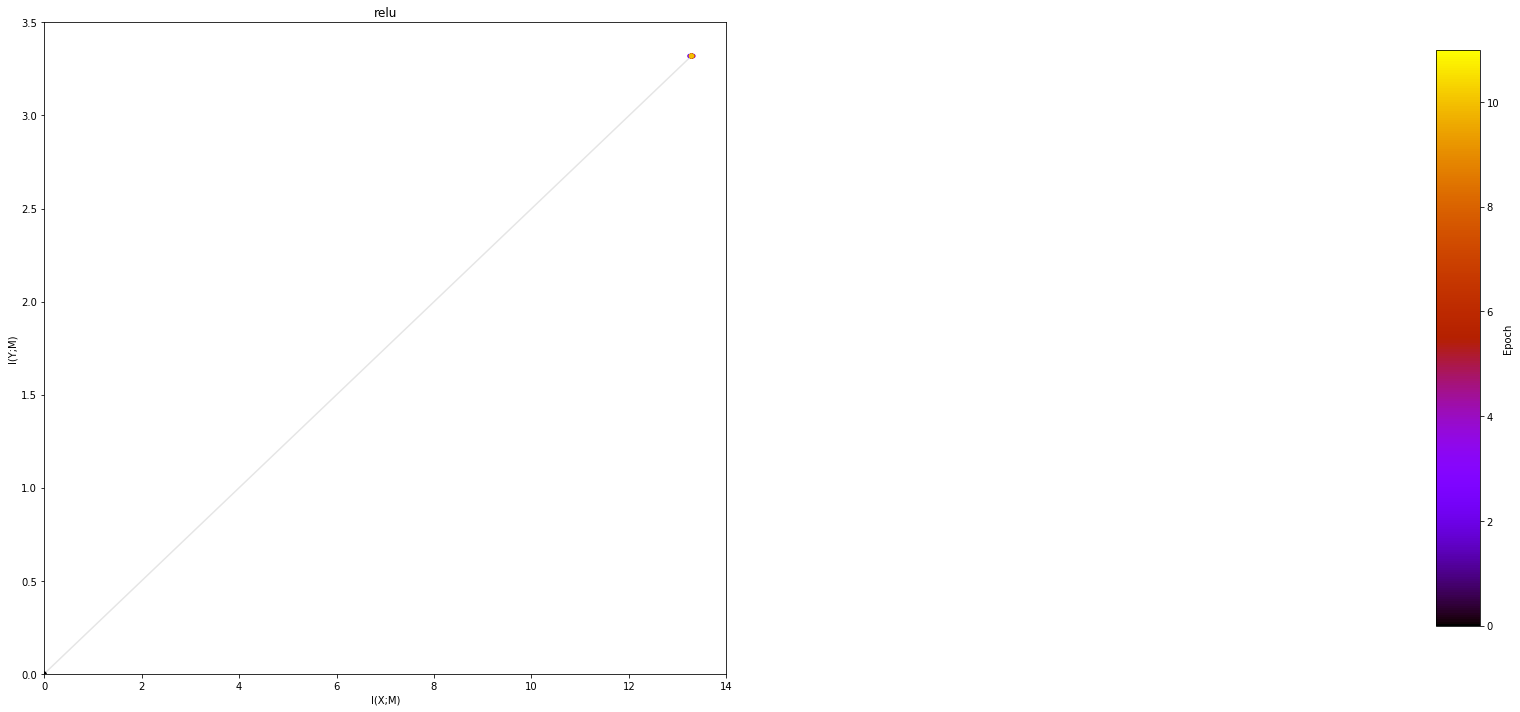

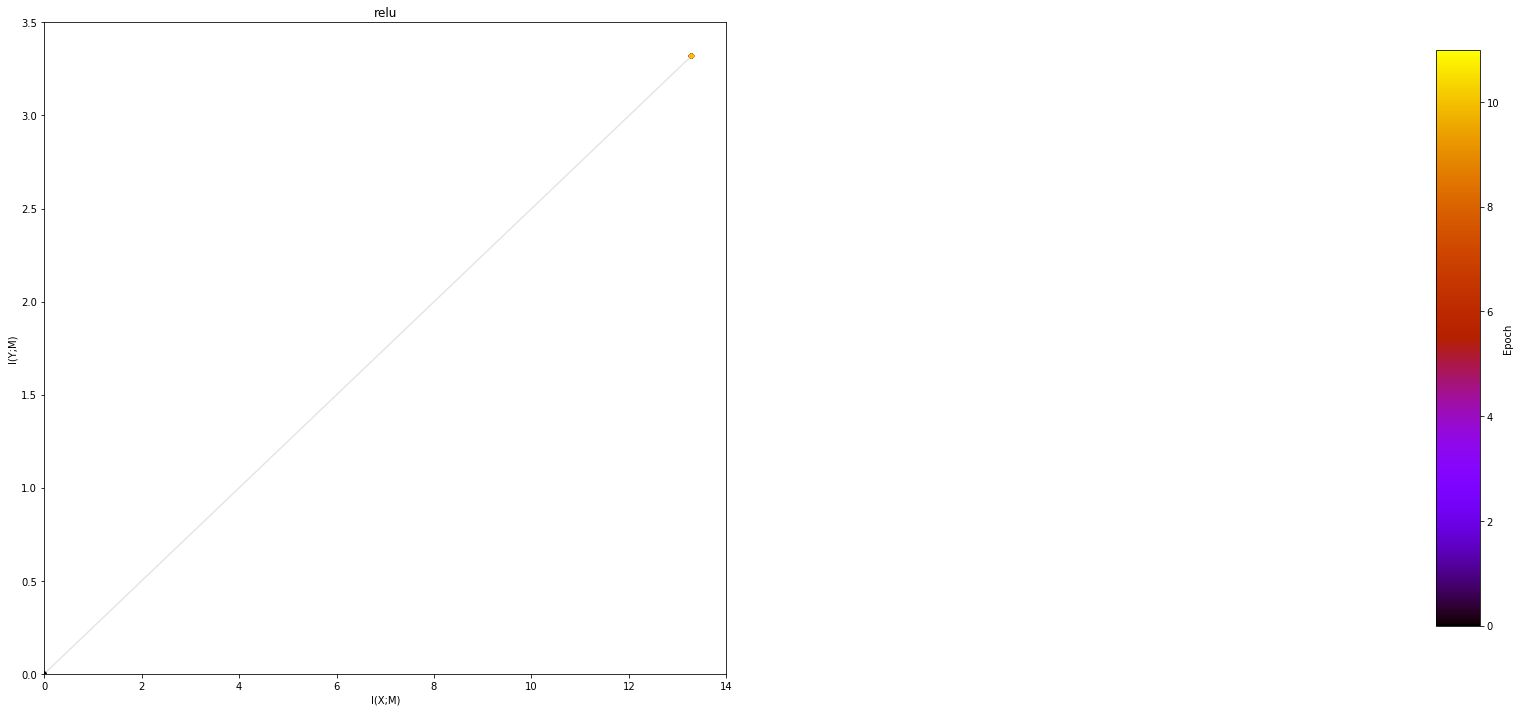

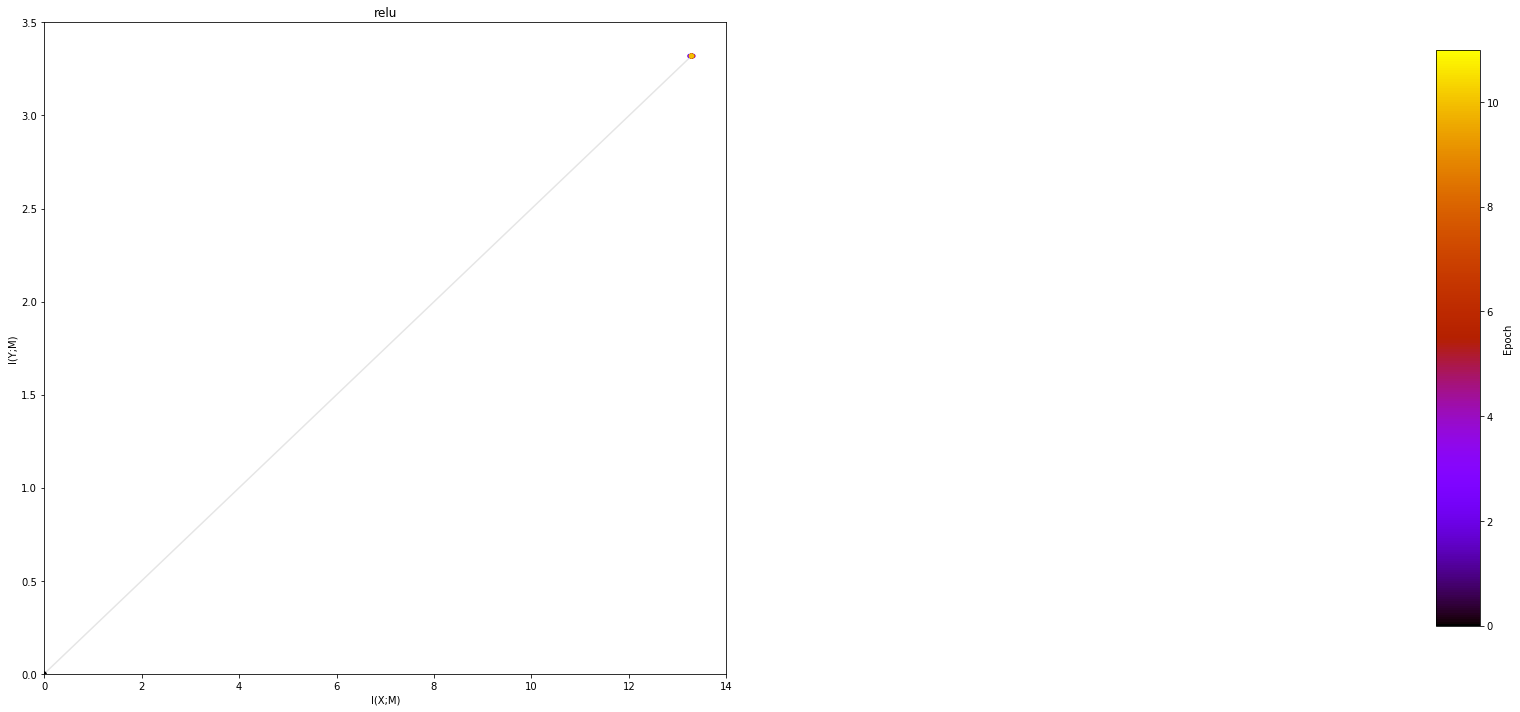

In [15]:
import matplotlib.pyplot as plt
#max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures.values())
#max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures_10.values())
#max_epoch = max( (max(vals.keys()) if len(vals) else 0) for vals in measures_20.values())
sm = plt.cm.ScalarMappable(cmap='gnuplot', norm=plt.Normalize(vmin=0, vmax=COLORBAR_MAX_EPOCHS))
sm._A = []

#fig=plt.figure(figsize=(10,5))
for measures in [measures, measures_10, measures_20]:
    fig=plt.figure(figsize=(20,10))
    #for actndx, (activation, vals) in enumerate(measures.items()):
    #for actndx, (activation, vals) in enumerate(measures_10.items()):
    for actndx, (activation, vals) in enumerate(measures.items()):
        epochs = sorted(vals.keys())
        if not len(epochs):
            continue
        plt.subplot(1,2,actndx+1)    
        for epoch in epochs:
            c = sm.to_rgba(epoch)
            xmvals = np.array(vals[epoch]['MI_XM_'+infoplane_measure])[PLOT_LAYERS]
            ymvals = np.array(vals[epoch]['MI_YM_'+infoplane_measure])[PLOT_LAYERS]

            plt.plot(xmvals, ymvals, c=c, alpha=0.1, zorder=1)
            plt.scatter(xmvals, ymvals, s=20, facecolors=[c for _ in PLOT_LAYERS], edgecolor='none', zorder=2)
    
        plt.ylim([0, 3.5])
        plt.xlim([0, 14])
        #plt.ylim([0, 3.5])
        #plt.xlim([0, 14])
        plt.xlabel('I(X;M)')
        plt.ylabel('I(Y;M)')
        plt.title(activation)
    
    cbaxes = fig.add_axes([1.0, 0.125, 0.03, 0.8]) 
    plt.colorbar(sm, label='Epoch', cax=cbaxes)
    plt.tight_layout()
    plt.show()

if DO_SAVE:
    plt.savefig('plots/' + DIR_TEMPLATE % ('infoplane_'+ARCH),bbox_inches='tight')  